<a href="https://colab.research.google.com/github/Vani-Kumari/capsuleEndoscopy/blob/main/vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from glob import glob
import matplotlib.pyplot as plt

In [ ]:
# Paths to your training and validation datasets
train_data_dir = '/content/drive/MyDrive/Capsule Endoscopy Dataset/train_dataset'
test_data_dir = '/content/drive/MyDrive/Capsule Endoscopy Dataset/Test_Dataset'

In [ ]:
# Parameters
img_height, img_width = 224, 224
batch_size = 32
num_classes = 8
epochs = 50
learning_rate = 1e-4

In [ ]:
# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important for evaluating the model correctly
)

Found 4017 images belonging to 8 classes.
Found 338 images belonging to 8 classes.


In [ ]:
# Load VGG16 pre-trained model + higher level layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))


58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
# Freeze the layers which you don't want to train
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Dropout

In [ ]:
# Adding custom layers
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator
)

Epoch 1/50
126/126 [==============================] - 3064s 24s/step - loss: 1.4159 - accuracy: 0.4603 - val_loss: 0.9498 - val_accuracy: 0.6243
Epoch 2/50
126/126 [==============================] - 108s 857ms/step - loss: 0.9756 - accuracy: 0.6126 - val_loss: 0.7024 - val_accuracy: 0.7367
Epoch 3/50
126/126 [==============================] - 110s 871ms/step - loss: 0.8370 - accuracy: 0.6589 - val_loss: 0.7592 - val_accuracy: 0.6657
Epoch 4/50
126/126 [==============================] - 107s 847ms/step - loss: 0.7426 - accuracy: 0.7025 - val_loss: 0.6133 - val_accuracy: 0.7633
Epoch 5/50
126/126 [==============================] - 109s 862ms/step - loss: 0.7308 - accuracy: 0.7058 - val_loss: 0.5929 - val_accuracy: 0.7663
Epoch 6/50
126/126 [==============================] - 106s 835ms/step - loss: 0.6769 - accuracy: 0.7311 - val_loss: 0.5253 - val_accuracy: 0.8047
Epoch 7/50
126/126 [==============================] - 107s 851ms/step - loss: 0.6651 - accuracy: 0.7421 - val_loss: 0.5203 - 

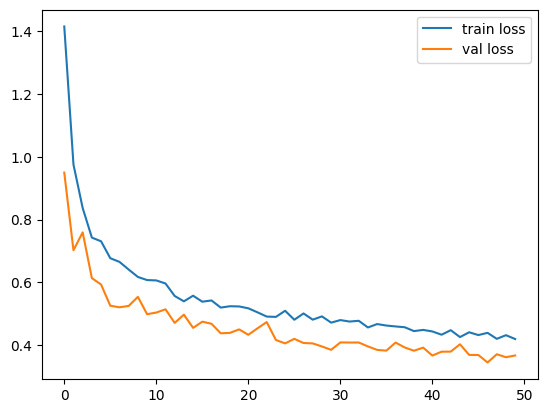

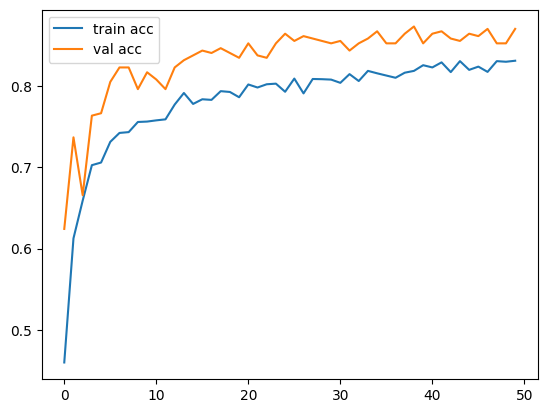

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
# Save the model
model.save('capsule_endoscopy_vgg16.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy * 100:.2f}%')


11/11 [==============================] - 6s 518ms/step - loss: 0.3666 - accuracy: 0.8698
Test accuracy: 86.98%


In [ ]:
# Make predictions on the test dataset
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes


11/11 [==============================] - 7s 630ms/step


In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)


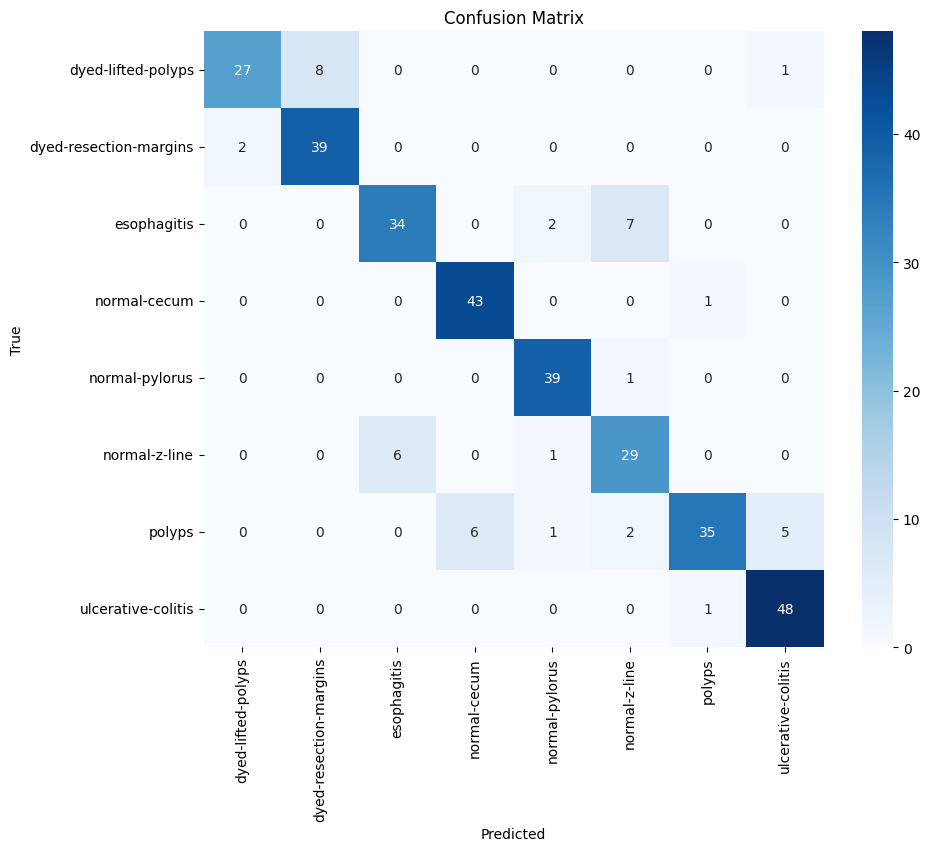

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
# Compute all classification metrics
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)
support = cm.sum(axis=1)


In [ ]:
print(f'Accuracy: {accuracy_score(y_true, y_pred) * 100:.2f}%')
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Support:', support)


Accuracy: 86.98%
Precision: [0.93103448 0.82978723 0.85       0.87755102 0.90697674 0.74358974
 0.94594595 0.88888889]
Recall: [0.75       0.95121951 0.79069767 0.97727273 0.975      0.80555556
 0.71428571 0.97959184]
F1 Score: [0.83076923 0.88636364 0.81927711 0.92473118 0.93975904 0.77333333
 0.81395349 0.93203883]
Support: [36 41 43 44 40 36 49 49]


In [ ]:
# Print classification report
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

Classification Report
                        precision    recall  f1-score   support

    dyed-lifted-polyps       0.93      0.75      0.83        36
dyed-resection-margins       0.83      0.95      0.89        41
           esophagitis       0.85      0.79      0.82        43
          normal-cecum       0.88      0.98      0.92        44
        normal-pylorus       0.91      0.97      0.94        40
         normal-z-line       0.74      0.81      0.77        36
                polyps       0.95      0.71      0.81        49
    ulcerative-colitis       0.89      0.98      0.93        49

              accuracy                           0.87       338
             macro avg       0.87      0.87      0.87       338
          weighted avg       0.87      0.87      0.87       338

